In [1]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp310-cp310-linux_x86_64.whl size=205172 sha256=57a5b82baeb7bb859f65d408d583a4d5b3d57b52137334c0552b75bf17e6af82
  Stored in directory: /root/.cache/pip/wheels/af/a9/3e/3e5d59ee41664eb31a4e6de67d1846f86d16d93c45f277c4e7
Successfully built hnswlib


# Helper

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
import random
import hnswlib
import time
import cv2
from sklearn.model_selection import train_test_split

plt.rcParams['font.size'] = 16

class HNSW:
    start=0
    model=None
    index2names={}
    
    def __init__(self, model, images):
        self.model=model
        for name in images:
            self.index2names[self.start] = name.split('/')[-1]
            self.start += 1
        
    def updateModel(self, model):
        self.model=model
        
    def updateIndex(self, images):
        for name in images:
            self.index2names[self.start] = name
            self.start += 1
        
        
def getEmbeddings(images, path, encoder=None):
    images_arr = []
    img_size = 224
    for image in images:
        image = cv2.imread(os.path.join(path,image))
#         image = image[:,:,::-1]
        image = cv2.resize(image,(img_size,img_size))
        image = image/255
        images_arr.append(image)
        
    if encoder is None:
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
        for layer in base_model.layers:
            layer.trainable = False

        input_layer = Input(shape=(224, 224, 3))
        x = base_model(input_layer)
        output = GlobalAveragePooling2D()(x)
        encoder = Model(inputs=input_layer, outputs=output)

    embeddings = encoder.predict(np.array(images_arr), verbose=1)
    
    return encoder, embeddings

def train(images, path):
    encoder, embeddings = getEmbeddings(images, path)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)  # Normalize embeddings

    f = embeddings.shape[1]
    model = hnswlib.Index(space='cosine', dim=f)
    model.init_index(max_elements=15000, ef_construction=200, M=32)
    model.set_ef(50)
    model.add_items(embeddings)

    hnsw = HNSW(model, images)
    return encoder, hnsw

def addData(images, path, encoder, model):
    _, embeddings = getEmbeddings(images, path, encoder)
    model.model.add_items(embeddings)
    model.updateIndex(images)
    return model

def predict(image, path, model, encoder, k=10):
    _, embeddings = getEmbeddings([image], path, encoder)
    labels, distances = model.model.knn_query(embeddings, k=k)
    labels = [[model.index2names[val] for val in label] for label in labels]
    return labels

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Dataset Generator

In [3]:
path = '/kaggle/input/fruitdata/Fruits_Data'

In [4]:
all_images = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
# Split into train and test sets (80% train, 20% test)
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
# Verify the splits
print(f"Total images: {len(all_images)}")
print(f"Training images: {len(train_images)}")
print(f"Testing images: {len(test_images)}")


Total images: 9981
Training images: 7984
Testing images: 1997


# Training

In [5]:
# Train the HNSW model
encoder, model = train(train_images,path)

250/250 [==============================] - 13s 33ms/step


In [6]:
# Save the encoder model
encoder.save("fruit_encoder_model")
# Save the HNSW index
model.model.save_index("fruit_hnsw_index.bin")

# Save the `index2names` mapping
import pickle
with open("index2names.pkl", "wb") as f:
    pickle.dump(model.index2names, f)


In [7]:
!zip -r file.zip /kaggle/working/fruit_encoder_model
from IPython.display import FileLink
FileLink(r'file.zip')

  adding: kaggle/working/fruit_encoder_model/ (stored 0%)
  adding: kaggle/working/fruit_encoder_model/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/fruit_encoder_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/fruit_encoder_model/assets/ (stored 0%)
  adding: kaggle/working/fruit_encoder_model/saved_model.pb (deflated 91%)
  adding: kaggle/working/fruit_encoder_model/variables/ (stored 0%)
  adding: kaggle/working/fruit_encoder_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/fruit_encoder_model/variables/variables.index (deflated 76%)


/kaggle/working/file.zip

In [8]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

# Prediction

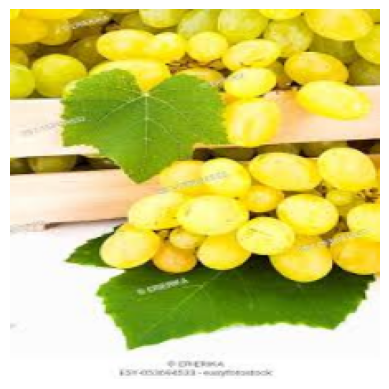

In [9]:
# Read the image
img = cv2.imread(os.path.join(path, 'Grape1002.jpeg'))

# Resize the image
img = cv2.resize(img, (224, 224))

# Normalize the image
img = img / 255.0

# Convert to uint8 for OpenCV
img_uint8 = (img * 255).astype('uint8')

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis('off')  # Optional: Hides the axis
plt.show()

In [10]:
labels = predict(
    '/kaggle/input/fruitdata/Fruits_Data/Grape1022.jpeg',
    path,
    model,
    encoder,
    k=10
)
labels

1/1 [==============================] - 0s 455ms/step


[['Grape1022.jpeg',
  'Grape1797.jpeg',
  'Grape1829.jpeg',
  'Grape1650.jpeg',
  'Grape815.jpeg',
  'Grape1763.jpeg',
  'Grape214.jpeg',
  'Grape895.jpeg',
  'Grape1731.jpeg',
  'Grape1686.jpeg']]

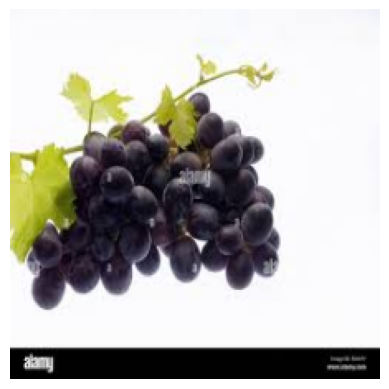

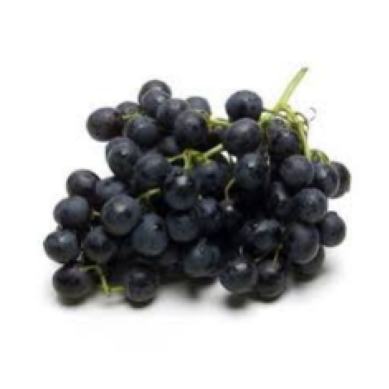

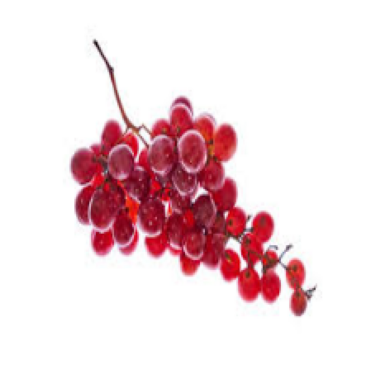

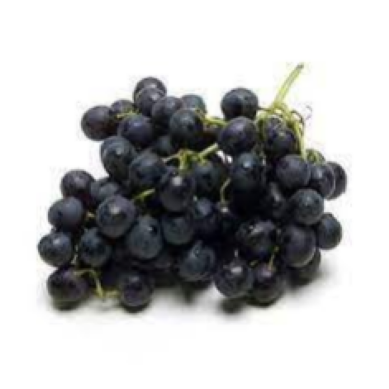

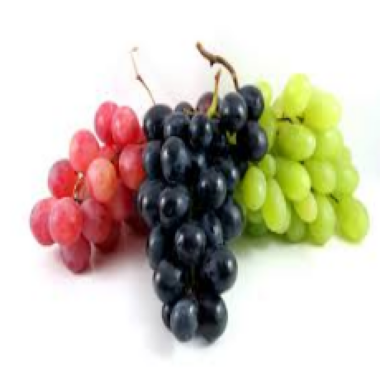

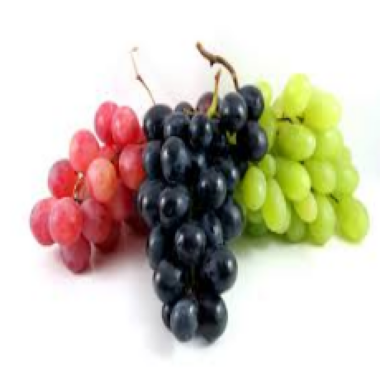

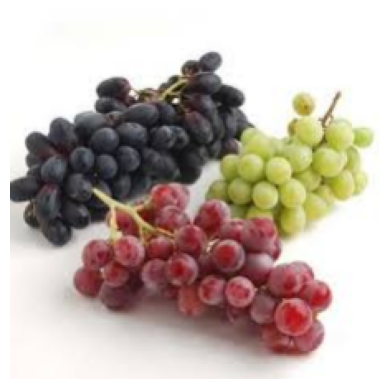

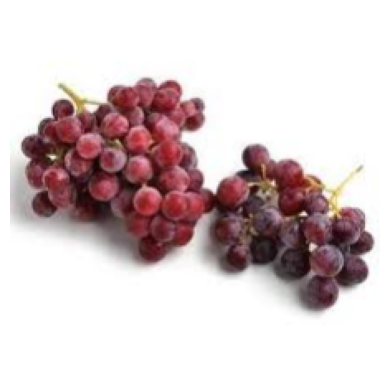

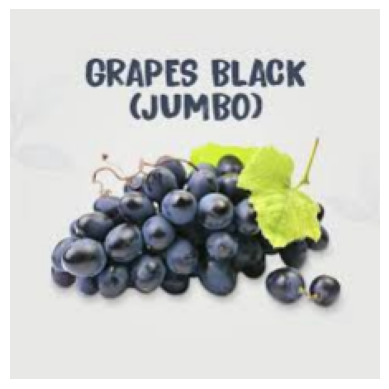

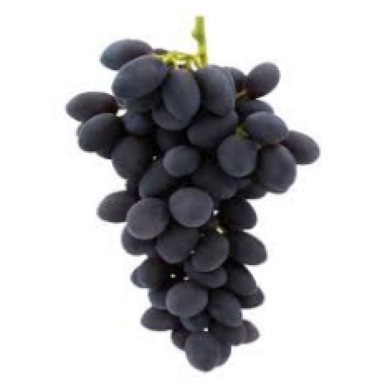

In [11]:
for pred in labels[0]:
    img = cv2.imread(os.path.join(path, pred))
    img = cv2.resize(img,(224,224))
    img = img/255
    # Convert to uint8 for OpenCV
    img_uint8 = (img * 255).astype('uint8')

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Optional: Hides the axis
    plt.show()

#App Fucntion

In [13]:
from tensorflow.keras.models import load_model
# Load the saved encoder model
encoder = load_model("/kaggle/working/fruit_encoder_model")

# Prediction

In [15]:

# Initialize and load the HNSW index
f = 1280  # Replace with the actual feature dimension of your embeddings
hnsw_model = hnswlib.Index(space='cosine', dim=f)
hnsw_model.load_index("/kaggle/working/fruit_hnsw_index.bin")


In [16]:
import pickle

# Load the index-to-names mapping
with open("/kaggle/working/index2names.pkl", "rb") as f:
    index2names = pickle.load(f)

# Reinitialize the HNSW object
class HNSW:
    start = 0
    model = None
    index2names = {}

    def __init__(self, model, images):
        self.model = model
        self.index2names = index2names

hnsw = HNSW(hnsw_model, [])


In [24]:
def predict(image_path, encoder, hnsw, k=5):
    # Load and preprocess the image
    img_size = 224
    image = cv2.imread(image_path)
    image = cv2.resize(image, (img_size, img_size))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    
    # Get embeddings
    embeddings = encoder.predict(image)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    # Query the HNSW index
    labels, distances = hnsw.model.knn_query(embeddings, k=k)
    results = [[hnsw.index2names[val] for val in label] for label in labels]
    return results

# Example usage
image_to_test = "/kaggle/input/fruitdata/Fruits_Data/Strawberry1014.jpeg"
predictions = predict(image_to_test, encoder, hnsw)
print("Top predictions:", predictions)


1/1 [==============================] - 0s 24ms/step
Top predictions: [['Strawberry1014.jpeg', 'Strawberry99.jpeg', 'Strawberry1324.jpeg', 'Grape1540.jpeg', 'Strawberry863.jpeg']]
